In [3]:
from packages.display.core import *
%pylab inline
pylab.rcParams['figure.figsize'] = (15, 2.5)

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [ ]:
%qtconsole

# ALMA Cycle 0

https://www.iram.fr/IRAMFR/ARC/documents/cycle0/ALMA_EarlyScience_Cycle0_HighestPriority.pdf

## 	Project 2011.0.00419.S

### 	

In [1]:
file_path = '../data/2011.0.00419.S/sg_ouss_id/group_ouss_id/member_ouss_2013-03-06_id/product/IRAS16547-4247_Jet_13CH3CN19-18.clean.fits'
noise_pixel = (15, 4)
train_pixels = [(135, 135), (135, 136), (136, 135), (136, 136)]

In [4]:
img = fits.open(file_path)

meta = img[0].data
hdr = img[0].header

# V axis
naxisv = hdr['NAXIS3']

onevpix = hdr['CDELT3']*0.000001
v0 = hdr['CRVAL3']*0.000001
v0pix = int(hdr['CRPIX3'])
vaxis = onevpix * (np.arange(naxisv)+1-v0pix) + v0

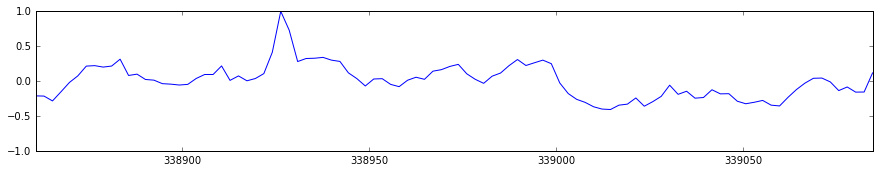

In [5]:
values = meta[0, :, train_pixels[0][0], train_pixels[0][1]] - np.mean(meta[0, :, train_pixels[0][0], train_pixels[0][1]])
values = values/np.max(values)

plt.plot(vaxis, values)

plt.xlim(np.min(vaxis), np.max(vaxis))
plt.ylim(-1, 1)
gca().xaxis.set_major_formatter(FormatStrFormatter('%d'))

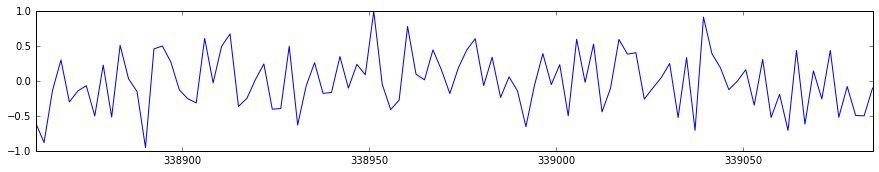

In [6]:
noise = meta[0, :, noise_pixel[0], noise_pixel[1]] - np.mean(meta[0, :, noise_pixel[0], noise_pixel[1]])
noise = noise/np.max(noise)

plt.plot(vaxis, noise)

plt.ylim(-1, 1)
plt.xlim(np.min(vaxis), np.max(vaxis))
gca().xaxis.set_major_formatter(FormatStrFormatter('%d'))

## Creation of Dictionary

We create the words necessary to fit a sparse coding model to the observed spectra in the previous created cube.
It returns a DataFrame with a vector for each theoretical line for each isotope in molist

In [7]:
cube_params = {
  'freq'     : vaxis[naxisv/2],
  'alpha'    : 0,
  'delta'    : 0,
  'spe_bw'   : naxisv*onevpix,
  'spe_res'  : onevpix*v0pix,
  's_f'      : 4,
  's_a'      : 0}

dictionary = gen_all_words(cube_params, True)

        Use :meth:`BinTableHDU.from_columns` for new BINARY tables or :meth:`TableHDU.from_columns` for new ASCII tables instead. [astropy.utils.decorators]
        Use :meth:`BinTableHDU.from_columns` for new BINARY tables or :meth:`TableHDU.from_columns` for new ASCII tables instead.


## Recalibration of Dictionary

In [9]:
prediction = pd.DataFrame([])

for train_pixel in train_pixels:

    dictionary_recal, detected_peaks = recal_words(file_path, dictionary, cube_params, 
                                                   train_pixel, noise_pixel)

    X = get_values_filtered_normalized(file_path, train_pixel, cube_params)

    y_train = get_fortran_array(np.asmatrix(X))
    dictionary_recal_fa = np.asfortranarray(dictionary_recal,
                                            dtype= np.double)

    lambda_param = 0
    for idx in range(0, len(detected_peaks)):
        if detected_peaks[idx] != 0:
            lambda_param += 1

    param = {
      'lambda1' : lambda_param,
      # 'L': 1,
      'pos' : True,
      'mode' : 0,
      'ols' : True,
      'numThreads' : -1}

    alpha = spams.lasso(y_train, dictionary_recal_fa, **param).toarray()
    total = np.inner(dictionary_recal_fa, alpha.T)

    for i in range(0, len(alpha)):
        iso_col = dictionary_recal.columns[i]
        if(not prediction.columns.isin([iso_col]).any()):
            prediction[iso_col] = alpha[i]
        else:
            prediction[iso_col] = prediction[iso_col]*alpha[i]

In [10]:
for p in prediction.columns:
    if(prediction[p][0] != 0):
        print(prediction[p])

0    23.710357
Name: H2CCCHCN-f338991.4157&&f338991.4292, dtype: float64
0    2.620756
Name: OS18O-f338931.0888, dtype: float64


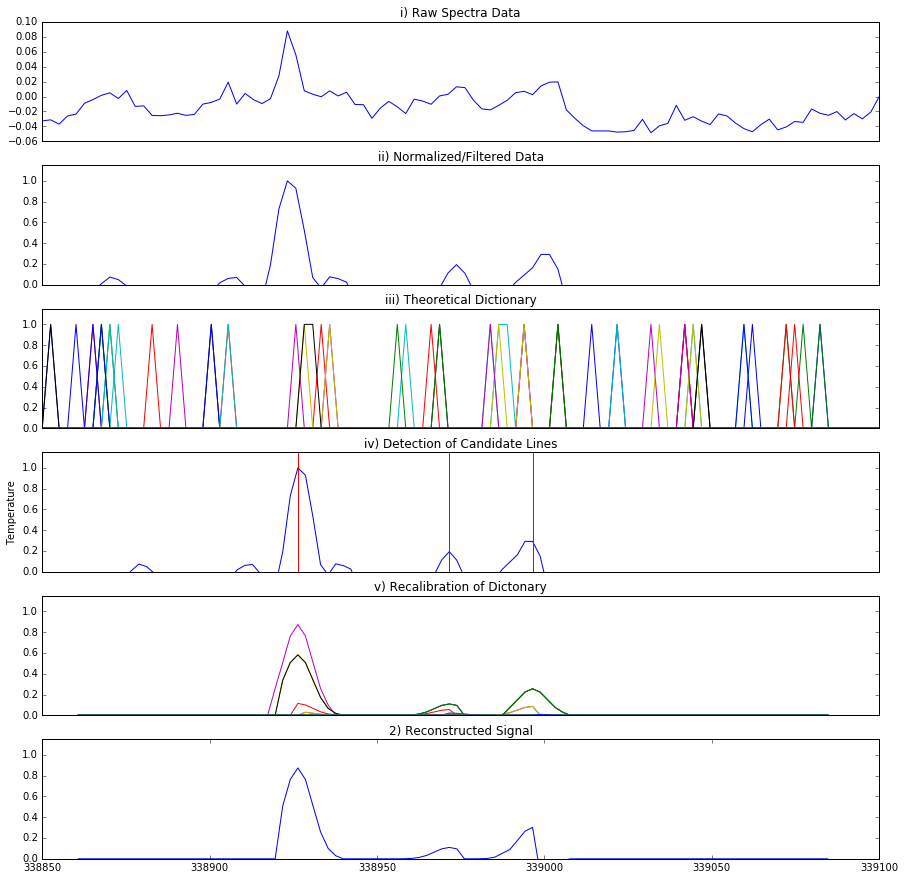

In [11]:
pylab.rcParams['figure.figsize'] = (15, 15)

# Step 1: Read Cube
ax = plt.subplot(6, 1, 1)
ax.set_title('i) Raw Spectra Data')
data = get_data_from_fits(file_path)  
y = data[0, :, train_pixel[0], train_pixel[1]]
plt.xticks([])
plt.plot(vaxis, y)
lines = get_lines_from_fits(file_path)
for line in lines:
    # Shows lines really present
    isotope_frequency = int(line[1])
    isotope_name = line[0] + "-f" + str(line[1])
    plt.axvline(x=isotope_frequency, ymin=0, ymax= 3, color='g')

# 2. Normalize, filter dada
ax = plt.subplot(6, 1, 2)
ax.set_title('ii) Normalized/Filtered Data')
plt.ylim(ymin =0,ymax = 1.15)
y = get_values_filtered_normalized(file_path, train_pixel, cube_params)
plt.xticks([])
plt.plot(vaxis, y)

# 3. Possible Words
ax = plt.subplot(6, 1, 3)
ax.set_title('iii) Theoretical Dictionary')
plt.ylim(ymin =0,ymax = 1.15)
plt.xticks([])
plt.plot(vaxis, dictionary)

# 4. Detect Lines
ax = plt.subplot(6, 1, 4)
ax.set_title('iv) Detection of Candidate Lines')
plt.ylim(ymin =0,ymax = 1.15)
plt.plot(vaxis, y)
plt.xticks([])
plt.ylabel("Temperature")
for idx in range(0, len(detected_peaks)):
    if detected_peaks[idx] != 0:
        plt.axvline(x=vaxis[idx], ymin=0, ymax= 1, color='r')

# 6. Recalibrate Dictionary
ax = plt.subplot(6, 1, 5)
ax.set_title('v) Recalibration of Dictonary')
plt.ylim(ymin =0,ymax = 1.15)
plt.plot(vaxis, dictionary_recal_fa)
plt.xticks([])

# 6. Recover Signal
ax = plt.subplot(6, 1, 6)
ax.set_title('2) Reconstructed Signal')
plt.ylim(ymin =0,ymax = 1.15)

plt.plot(vaxis, total)

gca().xaxis.set_major_formatter(FormatStrFormatter('%d'))

In [ ]:
for i in range(0, len((results[0] > 0))):
    if((results[0] > 0)[i]):
        print(dictionary_recal.columns[i])
        print(i)

In [ ]:
for i in range(0, len(dictionary.index)):
    print(calculate_probability(alpha, dictionary.index[i], dictionary_recal))
    print(dictionary.index[i])